In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

from pathlib import Path
import json
import yaml

import procgen

from IPython.display import clear_output

2023-04-13 19:28:17.692825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 19:28:18.074735: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 19:28:19.035494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-13 19:28:19.035646: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import gym
env = gym.make('procgen-coinrun-v0')
# env = gym.make('procgen-coinrun-v0', use_backgrounds=False, restrict_themes=True)

In [9]:
env.env.env.env

<CEnv lib_path=/usr/local/lib/python3.10/dist-packages/procgen/data/prebuilt/libenv.so options={'center_agent': True, 'use_generated_assets': False, 'use_monochrome_assets': False, 'restrict_themes': False, 'use_backgrounds': True, 'paint_vel_info': False, 'distribution_mode': 1, 'env_name': 'coinrun', 'num_levels': 0, 'start_level': 0, 'num_actions': 15, 'use_sequential_levels': False, 'debug_mode': 0, 'rand_seed': 504113423, 'num_threads': 0, 'render_human': False, 'resource_root': '/usr/local/lib/python3.10/dist-packages/procgen/data/assets/'}>

In [117]:
def plt_render(obs, reward=None, clear=True):
    plt.imshow(obs)
    if reward is not None:
        plt.title(f"Reward: {reward}")
    plt.axis('off')
    plt.show()
    if clear:
        clear_output(wait=True)

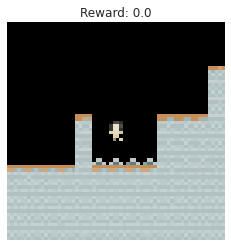

In [72]:
obs = env.reset()
reward = 0
try:
    while True:
        obs, reward, done, info = env.step(env.action_space.sample())
        plt_render(obs, reward)
        if done:
            break

except KeyboardInterrupt:
    clear_output(wait=True)
    plt_render(obs, reward)

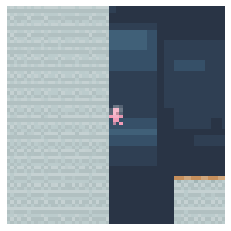

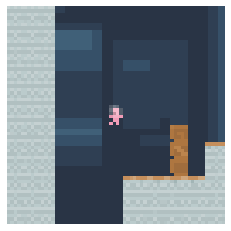

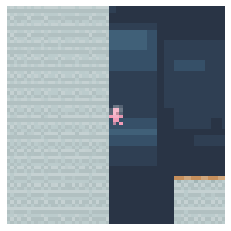

In [4]:
for _ in range(10):
    obs, *_ = env.step(env.action_space.sample())

plt_render(obs, clear=False)
state = env.env.env.get_state()

for _ in range(100):
    obs, *_ = env.step(env.action_space.sample())

plt_render(obs, clear=False)
env.env.env.set_state(state)

plt_render(env.env.observe()[1][0])

In [100]:
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.policies import TFPolicy
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.policies.random_py_policy import RandomPyPolicy
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [101]:
gym_env = GymWrapper(env)
gym_env._action_is_discrete = False  # gym wrapper takes action from numpy array unless this is set

tf_env = TFPyEnvironment(gym_env)
tf_env.reset()

random_policy = RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)

In [118]:
tf_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [119]:
random_policy.action(tf_env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([12])>, state=(), info=())

In [120]:
from mlrl.utils import render_utils

In [121]:
import cv2

def render_fn(tf_env, *_):
    cenv = tf_env._env.envs[0].env.env
    img = cenv.observe()[1]['rgb'][0]
    img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                     interpolation=cv2.INTER_NEAREST)
    return img

In [14]:
render_utils.embed_mp4(render_utils.save_policy_eval_video(
    random_policy, tf_env, render_fn, 'video', max_steps=15*30), width=256, height=256)

In [122]:
class Autoencoder(tf.keras.Model):

    def __init__(self, enc_dim=64, n_channels=3):
        super(Autoencoder, self).__init__()
        
        self.encoding_dim = enc_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), 
                                   activation='relu', 
                                   input_shape=(64, 64, n_channels)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(enc_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(units=8*8*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=2, padding='same',
                activation='sigmoid'
            ),
        ])
        
    def encode(self, inputs, training=False):
        input_encodings = self.encoder(inputs, training=training)
        return input_encodings

    def decode(self, encoding, training=False):
        return self.decoder(encoding, training=training)
    
    def call(self, inputs, training=False):
        enc = self.encode(inputs, training=training)
        return self.decode(enc, training=training)

In [123]:
ts = tf_env.current_time_step()

In [124]:
autoencoder = Autoencoder()
autoencoder(ts.observation).shape

TensorShape([1, 64, 64, 3])

In [125]:
class QNet(tf.keras.Model):
    
    def __init__(self, encoder, n_actions):
        super(QNet, self).__init__()
        self.normalize = tf.keras.layers.Rescaling(scale=1./255)
        self.grayscale = tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x))
        self.encoder = encoder
        self.n_actions = n_actions
        self.q = tf.keras.layers.Dense(n_actions)

    def preprocess(self, x):
        x = self.normalize(x)
        x = self.grayscale(x)
        return x
    
    def call(self, x, training=False):
        # x = self.preprocess(x)
        z = self.encoder(x, training=training)
        return self.q(z, training=training)

In [132]:
n_actions = 1 + int(tf_env.action_spec().maximum)
# autoencoder = Autoencoder(n_channels=1)
autoencoder = Autoencoder()
q_net = QNet(autoencoder.encoder, n_actions)

In [134]:
# autoencoder(q_net.preprocess(ts.observation)).shape

In [135]:
q_net(ts.observation)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 12.161365 ,  -6.8474054,  -2.9786396,  28.725822 ,  21.98292  ,
          6.602689 ,  -3.9568   , -32.559658 , -24.766476 ,  -1.5703712,
         20.926344 , -16.358196 ,  -6.737111 ,  -5.3764114,   6.322547 ]],
      dtype=float32)>

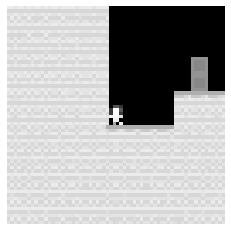

In [136]:
img = q_net.preprocess(ts.observation)[0].numpy()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [137]:
run = 'run-16806123746873610'
best_epoch = 81
q_net.load_weights(f'./runs/ddqn_agent/{run}/model_weights/q_net_best_{best_epoch}_6.022305')

In [21]:
from tf_agents.agents.dqn.dqn_agent import DdqnAgent
from tf_agents.networks.sequential import Sequential

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    train_step_counter=train_step_counter
)
# print('Initialising agent...')
agent.initialize()

In [23]:
render_utils.embed_mp4(render_utils.save_policy_eval_video(
    agent.collect_policy, tf_env, render_fn, 'video', max_steps=15*60*2), width=256, height=256)

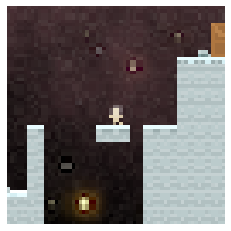

In [32]:
ts = tf_env.current_time_step()
plt.imshow(ts.observation[0])
plt.axis('off')
plt.show()

In [38]:
cenv = tf_env.envs[0].env.env

In [42]:
cenv.__dict__

{'combos': [('LEFT', 'DOWN'),
  ('LEFT',),
  ('LEFT', 'UP'),
  ('DOWN',),
  (),
  ('UP',),
  ('RIGHT', 'DOWN'),
  ('RIGHT',),
  ('RIGHT', 'UP'),
  ('D',),
  ('A',),
  ('W',),
  ('S',),
  ('Q',),
  ('E',)],
 'options': {'center_agent': True,
  'use_generated_assets': False,
  'use_monochrome_assets': False,
  'restrict_themes': False,
  'use_backgrounds': True,
  'paint_vel_info': False,
  'distribution_mode': 1,
  'env_name': 'coinrun',
  'num_levels': 0,
  'start_level': 0,
  'num_actions': 15,
  'use_sequential_levels': False,
  'debug_mode': 0,
  'rand_seed': 1367723360,
  'num_threads': 0,
  'render_human': False,
  'resource_root': '/usr/local/lib/python3.8/dist-packages/procgen/data/assets/'},
 '_reuse_arrays': False,
 'num': 1,
 '_ffi': <cffi.api.FFI at 0x7fd5c4782280>,
 '_lib_path': '/usr/local/lib/python3.8/dist-packages/procgen/data/prebuilt/libenv.so',
 '_c_lib': <cffi.api._make_ffi_library.<locals>.FFILibrary at 0x7fd4d61b8160>,
 '_options': {'center_agent': True,
  'use_ge

<AxesSubplot:>

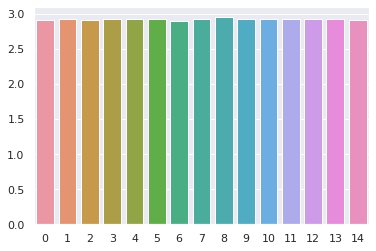

In [33]:
sns.barplot(x=np.arange(n_actions), y=q_net(ts.observation)[0].numpy())

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[2.92112  , 2.9237466, 2.9198418, 2.9241848, 2.9218557, 2.9242399,
        2.9011636, 2.9260917, 2.9538193, 2.9232347, 2.92176  , 2.922986 ,
        2.9254408, 2.924779 , 2.9209092]], dtype=float32)>

In [19]:
from mlrl.runners.eval_runner import EvalRunner
from tf_agents import environments

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [21]:
random_eval_runner = EvalRunner(
                16000,
                environments.BatchedPyEnvironment([
                    GymWrapper(gym.make('procgen-coinrun-v0'))
                    for _ in range(16)
                ]),
                random_policy)

random_eval_runner.run()

16011/16000 [==============================] - 18s 1ms/step - AverageReturn: 1.8988
Evaluation stats:
EvalNumberOfEpisodes: 21.000, EvalEnvironmentSteps: 16011.000, EvalAverageReturn: 3.810, EvalAverageEpisodeLength: 647.667, EvalTime: 18.325


{'EvalNumberOfEpisodes': 21,
 'EvalEnvironmentSteps': 16011,
 'EvalAverageReturn': 3.8095238,
 'EvalAverageEpisodeLength': 647.6667,
 'EvalTime': 18.32514762878418}

In [26]:
eval_runner = EvalRunner(
                16000,
                environments.BatchedPyEnvironment([
                    GymWrapper(gym.make('procgen-coinrun-v0'))
                    for _ in range(16)
                ]),
                agent.policy)
eval_runner.run()

16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 951.062, EvalTime: 19.402


{'EvalNumberOfEpisodes': 16,
 'EvalEnvironmentSteps': 16000,
 'EvalAverageReturn': 0.0,
 'EvalAverageEpisodeLength': 951.0625,
 'EvalTime': 19.40189242362976}

In [20]:
from typing import Optional, List
from tf_agents.drivers import py_driver


def create_policy_eval_video_frames(
        policy, env,
        render_fn=None,
        max_envs_to_show: Optional[int] = None,
        stack='vertical',
        steps: int = 60) -> List[np.ndarray]:
    """
    Creates a video of the policy acting in the given environment.
    If the environment is a batched environment, then multiple episodes
    will be shown stacked vertically.

    Args:
        policy (TFPolicy): The policy to evaluate.
        meta_env (TFEnvironment): The environment to evaluate the policy in.
        max_envs_to_show (Optional[int]): The maximum number of environments to show.
        steps (int): The maximum number of steps to run the policy for.

    Returns:
        List[np.ndarray]: A list of numpy arrays containing the frames of the video.
    """
    render_fn = render_fn or (lambda e: e.render())

    frames = []

    def observe(_):
        frames.append(render_fn(env))

    driver = py_driver.PyDriver(
        env, policy,
        max_steps=steps,
        observers=[observe]
    )
    
    driver.run(env.current_time_step())

    return frames


n_video_envs = 12

video_env = environments.BatchedPyEnvironment([
    GymWrapper(gym.make('procgen-coinrun-v0'))
    for _ in range(n_video_envs)
])
video_env.reset()


def get_grid_dim(n):
    sqrt_n = np.sqrt(n)
    p = 1
    for i in range(1, int(np.ceil(np.sqrt(n)))):
        if n % i == 0:
            p = n / i
    q = n / p
    return int(p), int(q)


p, q = get_grid_dim(n_video_envs)


def render_fn(batched_env, *_):
    
    def render_env(env):
        cenv = env.env
        img = cenv.observe()[1][0]
        img = cv2.resize(img, (4*img.shape[0], 4*img.shape[1]),
                         interpolation=cv2.INTER_NEAREST)
        return img
    
    frames = [
        render_env(e)
        for i, e in enumerate(batched_env.envs)
    ]
    
    return np.concatenate([
        np.concatenate(frames[i*q:(i+1)*q]) for i in range(p)
    ], axis=1)

In [23]:
from mlrl.runners.dqn_runner import DQNRun

fps = 15

collect_env = environments.BatchedPyEnvironment([
    GymWrapper(gym.make('procgen-coinrun-v0'))
    for _ in range(16)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_step_counter = tf.Variable(0)

agent = DdqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    target_update_period=20000,
    train_step_counter=train_step_counter
)
agent.initialize()

eval_runner = EvalRunner(
        16000,
        environments.BatchedPyEnvironment([
            GymWrapper(gym.make('procgen-coinrun-v0'))
            for _ in range(16)
        ]),
        agent.policy)


from mlrl.utils.render_utils import save_video

def create_video(policy, video_file):
    frames = create_policy_eval_video_frames(
        policy, video_env, 
        render_fn=render_fn, steps=15*60*n_video_envs
    )
    return save_video(frames, video_file, fps=15)


dqn_run = DQNRun(
    agent, collect_env, q_net,
    eval_runner=eval_runner,
    create_video_fn=create_video,
    video_freq=5,
    train_steps_per_epoch=10000,
    num_epochs=500
)

In [24]:
dqn_run.create_evaluation_video('video')

Failed to create evaluation video: You must call wandb.init() before wandb.log()


In [27]:
from mlrl.utils.render_utils import embed_mp4

embed_mp4(f'{dqn_run.videos_dir}/video.mp4')

In [28]:
dqn_run.execute()

Setting up run...


wandb: Currently logged in as: drcope (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting training...
Epoch 1/500
Running evaluation...
16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 1000.000, EvalTime: 19.354
10000/10000 [==============================] - 19s 2ms/step - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 1000.0000 - EvalTime: 19.3542
Epoch 2/500
16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 1000.000, EvalTime: 19.289
Saving model weights to ./runs//ddqn_agent/run-16806123746873610/model_weights/q_net_best_1_0.000000
10000/10000 [==============================] - 416s 42ms/step - TrainLoss: 3219.5084 - NumberOfEpisodes: 99.5505 - Envi

16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 1000.000, EvalTime: 18.279
10000/10000 [==============================] - 405s 40ms/step - TrainLoss: 0.1243 - NumberOfEpisodes: 329.2602 - EnvironmentSteps: 79686.8095 - AverageReturn: 4.7201 - AverageEpisodeLength: 219.0432 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 1000.0000 - EvalTime: 18.2792
Epoch 12/500
16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 1000.000, EvalTime: 18.024
10000/10000 [==============================] - 387s 39ms/step - TrainLoss: 0.1248 - NumberOfEpisodes: 357.8970 - EnvironmentSteps: 7965

Epoch 21/500
16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 1.6427
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.625, EvalAverageEpisodeLength: 615.438, EvalTime: 18.451
10000/10000 [==============================] - 413s 41ms/step - TrainLoss: 0.1439 - NumberOfEpisodes: 401.7117 - EnvironmentSteps: 79614.3632 - AverageReturn: 4.3706 - AverageEpisodeLength: 179.8810 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.6250 - EvalAverageEpisodeLength: 615.4375 - EvalTime: 18.4508
Epoch 22/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 615.438, EvalTime: 19.980
10000/10000 [==============================] - 399s 40ms/step - TrainLoss: 0.1274 - NumberOfEpisodes: 330.1354 - EnvironmentSteps: 79

16013/16000 [==============================] - 21s 1ms/step - AverageReturn: 5.3037
Evaluation stats:
EvalNumberOfEpisodes: 259.000, EvalEnvironmentSteps: 16013.000, EvalAverageReturn: 5.830, EvalAverageEpisodeLength: 59.340, EvalTime: 20.692
Saving model weights to ./runs//ddqn_agent/run-16806123746873610/model_weights/q_net_best_26_5.830116
10000/10000 [==============================] - 420s 42ms/step - TrainLoss: 0.1172 - NumberOfEpisodes: 358.0167 - EnvironmentSteps: 79658.0562 - AverageReturn: 4.5182 - AverageEpisodeLength: 202.1042 - EvalNumberOfEpisodes: 259.0000 - EvalEnvironmentSteps: 16013.0000 - EvalAverageReturn: 5.8301 - EvalAverageEpisodeLength: 59.3398 - EvalTime: 20.6921
Epoch 28/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 4.9584
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 1.875, EvalAverageEpisodeLength: 621.375, EvalTime: 20.456
10000/10000 [==============================] - 3

Epoch 34/500
16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 636.812, EvalTime: 18.221
10000/10000 [==============================] - 392s 39ms/step - TrainLoss: 0.1287 - NumberOfEpisodes: 339.4265 - EnvironmentSteps: 79676.6408 - AverageReturn: 3.9525 - AverageEpisodeLength: 220.8780 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 636.8125 - EvalTime: 18.2209
Epoch 35/500
16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 636.812, EvalTime: 18.250
10000/10000 [==============================] - 389s 39ms/step - TrainLoss: 0.1237 - NumberOfEpisodes: 356.1453 - EnvironmentS

16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 794.375, EvalTime: 19.440
10000/10000 [==============================] - 404s 40ms/step - TrainLoss: 0.1144 - NumberOfEpisodes: 272.5889 - EnvironmentSteps: 79743.4629 - AverageReturn: 4.4549 - AverageEpisodeLength: 262.6117 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 794.3750 - EvalTime: 19.4396
Epoch 41/500
16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 794.375, EvalTime: 19.251
10000/10000 [==============================] - 415s 41ms/step - TrainLoss: 0.1136 - NumberOfEpisodes: 414.9657 - EnvironmentSteps: 79601.1

16000/16000 [==============================] - 18s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 756.625, EvalTime: 18.328
10000/10000 [==============================] - 393s 39ms/step - TrainLoss: 0.1117 - NumberOfEpisodes: 317.9614 - EnvironmentSteps: 79698.1005 - AverageReturn: 4.1196 - AverageEpisodeLength: 225.5052 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 756.6250 - EvalTime: 18.3277
Epoch 48/500
16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 756.625, EvalTime: 18.646
10000/10000 [==============================] - 391s 39ms/step - TrainLoss: 0.1097 - NumberOfEpisodes: 369.6021 - EnvironmentSteps: 79646.4

10000/10000 [==============================] - 395s 39ms/step - TrainLoss: 0.1156 - NumberOfEpisodes: 298.8524 - EnvironmentSteps: 79717.2033 - AverageReturn: 4.1149 - AverageEpisodeLength: 235.6198 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 756.6250 - EvalTime: 19.7524
Epoch 54/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 756.625, EvalTime: 19.701
10000/10000 [==============================] - 379s 38ms/step - TrainLoss: 0.1128 - NumberOfEpisodes: 435.1842 - EnvironmentSteps: 79580.8989 - AverageReturn: 4.5904 - AverageEpisodeLength: 168.9935 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 756.6250 - EvalTime: 19.7011
Epoch 55/500
16000/16000 [====

16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 756.625, EvalTime: 19.681
10000/10000 [==============================] - 381s 38ms/step - TrainLoss: 0.1413 - NumberOfEpisodes: 490.9220 - EnvironmentSteps: 79525.1729 - AverageReturn: 4.6341 - AverageEpisodeLength: 146.3644 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 756.6250 - EvalTime: 19.6813
Epoch 61/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 756.625, EvalTime: 19.520
10000/10000 [==============================] - 401s 40ms/step - TrainLoss: 0.1543 - NumberOfEpisodes: 387.9822 - EnvironmentSteps: 79628.0

16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 701.625, EvalTime: 19.232
10000/10000 [==============================] - 370s 37ms/step - TrainLoss: 0.1164 - NumberOfEpisodes: 356.0491 - EnvironmentSteps: 79660.0190 - AverageReturn: 4.3439 - AverageEpisodeLength: 202.0271 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 701.6250 - EvalTime: 19.2317
Epoch 68/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 701.625, EvalTime: 19.515
10000/10000 [==============================] - 369s 37ms/step - TrainLoss: 0.1228 - NumberOfEpisodes: 322.5365 - EnvironmentSteps: 79693.5

10000/10000 [==============================] - 370s 37ms/step - TrainLoss: 0.1326 - NumberOfEpisodes: 353.4420 - EnvironmentSteps: 79662.6276 - AverageReturn: 4.6236 - AverageEpisodeLength: 198.7171 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 701.6250 - EvalTime: 19.3940
Epoch 74/500
16015/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 17.000, EvalEnvironmentSteps: 16015.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 686.000, EvalTime: 19.332
10000/10000 [==============================] - 371s 37ms/step - TrainLoss: 0.1224 - NumberOfEpisodes: 373.4709 - EnvironmentSteps: 79642.5973 - AverageReturn: 4.6955 - AverageEpisodeLength: 193.6779 - EvalNumberOfEpisodes: 17.0000 - EvalEnvironmentSteps: 16015.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 686.0000 - EvalTime: 19.3318
Epoch 75/500
16000/16000 [====

16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 690.188, EvalTime: 19.414
10000/10000 [==============================] - 370s 37ms/step - TrainLoss: 0.1175 - NumberOfEpisodes: 323.0115 - EnvironmentSteps: 79692.0584 - AverageReturn: 4.1745 - AverageEpisodeLength: 222.3785 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 0.0000e+00 - EvalAverageEpisodeLength: 690.1875 - EvalTime: 19.4141
Epoch 81/500
16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 690.188, EvalTime: 19.469
10000/10000 [==============================] - 392s 39ms/step - TrainLoss: 0.1144 - NumberOfEpisodes: 337.7211 - EnvironmentSteps: 79678.3

16000/16000 [==============================] - 19s 1ms/step - AverageReturn: 7.1710
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 1.875, EvalAverageEpisodeLength: 733.000, EvalTime: 19.142
10000/10000 [==============================] - 391s 39ms/step - TrainLoss: 0.1144 - NumberOfEpisodes: 339.6297 - EnvironmentSteps: 79676.4370 - AverageReturn: 4.4265 - AverageEpisodeLength: 211.9184 - EvalNumberOfEpisodes: 16.0000 - EvalEnvironmentSteps: 16000.0000 - EvalAverageReturn: 1.8750 - EvalAverageEpisodeLength: 733.0000 - EvalTime: 19.1425
Epoch 87/500
16000/16000 [==============================] - 20s 1ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalNumberOfEpisodes: 16.000, EvalEnvironmentSteps: 16000.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 733.000, EvalTime: 19.679
10000/10000 [==============================] - 373s 37ms/step - TrainLoss: 0.1157 - NumberOfEpisodes: 333.9400 - EnvironmentSteps: 79682.1275 - Av

Epoch 93/500
 6678/10000 [===================>..........] - ETA: 2:06 - TrainLoss: 0.1358 - NumberOfEpisodes: 269.6668 - EnvironmentSteps: 53162.4081 - AverageReturn: 4.6140 - AverageEpisodeLength: 168.5384Run Interrupted!
Saving run config to <_io.TextIOWrapper name='./runs//ddqn_agent/run-16806123746873610/config.json' mode='w' encoding='UTF-8'>
Saving model weights to ./runs//ddqn_agent/run-16806123746873610/model_weights/q_net


{'EvalNumberOfEpisodes': [16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  266,
  16,
  16,
  17,
  16,
  16,
  18,
  259,
  16,
  16,
  16,
  16,
  17,
  16,
  16,
  16,
  261,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  17,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  269,
  16,
  16,
  258,
  16,
  16,
  16,
  16,
  16,
  16,
  16],
 'EvalEnvironmentSteps': [16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16006,
  16000,
  16000,
  16015,
  16000,
  16000,
  16015,
  16013,
  16000,
  16000,
  16000,
  16000,
  16015,
  16000,
  16000,
  16000,
  16011,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000,
  16000